# Binary Classification

In [3]:
# Let's download the mnist dataset
from keras.datasets import mnist
import numpy as np

C:\Users\Tim\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train.shape
# We need to flatten our images for sklearn
x_train = x_train.reshape(-1,28*28)

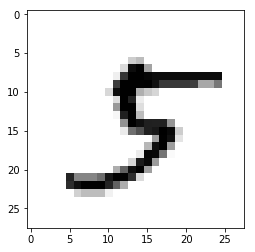

In [6]:
# Let's load an image and look at it
%matplotlib inline
import matplotlib.pyplot as plt

some_digit = x_train[36011]
some_digit = some_digit.reshape(28,28)
plt.imshow(some_digit, cmap=plt.cm.binary, interpolation='nearest')

In [7]:
y_train[36011]

5

Let's work on a binary classifier to determine if an image has a 5 or not

In [8]:
y_train_5 = (y_train == 5) # True for all 5's, False for any other digits
y_test_5 = (y_test == 5)

"Okay, now let's pick a classifier and train it... Scikit-Learn's `SGDClassifier` (Stochastic Gradient Descent) class has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for *online learning*)"

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(x_train, y_train_5) # 'The SGDClassifier relies on randomness during training (hence the name "stochastic").'

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

We are getting >95% accuracy on all folds of the training set, which seems great! However, the data is extremely skewed, with only 10% of the data being 5's and 90% not being such.

Even if the model was to guess 100% of the time that the label is not a 5, it would still get 90% accuracy, as seen below.

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

Instead of using accuracy, "a much better way to evaluate the performance of a classifier is to look at the *confusion matrix.* The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5's with 3's, you would look in the 5th row and the 3rd column."

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

`[ true negatives | false positives ]    ideal:`

`[ guessed not 5, | guessed 5,      ]    [m,0]`

`[ was not 5      | was not 5       ]    [0,n]`

`[----------------------------------]`

`[ false negatives| true positives  ] `

`[ guessed not 5, | guessed 5,      ]`

`[ was 5          | was 5           ]`

One way to look at the accuracy is through the percentage of correct positive predictions, known as the **precision** of the classifier:

precision = TP / (TP + FP)

"Precision is typically used along with another metric named **recall**" (or **sensitivity** or **true positive rate**).

recall = TP / (TP + FN)

"Scikit-Learn provides several function to compute classifier metrics, including precision and recall."

In [14]:
from sklearn.metrics import precision_score, recall_score

print('Precision score:', precision_score(y_train_5, y_train_pred)) # Percentage of claims that it is a 5 that are correct
print('Recall score:', recall_score(y_train_5, y_train_pred)) # Percentage of 5's that it was able to detect

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


When comparing two different classifiers, it is helpful to have just one number, which is what the F1 score is useful for. The F1 score is the *harmonic mean* of precision and recall.

In [15]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

"The F1 score favors classifiers that have similar precision and recall. This is not always what you want."

"In some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product... On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

"Unfortunately, you can't have it both ways: increasing precision reduces recall, and vice versa. This is called **precision/recall tradeoff.**"

### Precision/Recall Tradeoff
"To understand this tradeoff, let's look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a *decision function*, and if that score is greater than a threshold, it assign the instance to the positive class, or else it assigns it to the negative class."

With a high threshold, precision will go up, but recall will go down. In layman's terms, when the classifier predicts the instances to be 5's, it will be right most of the time, but it will miss plenty of instances that were in fact 5's.

With a low threshold, precision will go down, and recall will go up. So the classifier is less likely to miss any and all instances of 5's, but when it predicts a 5, it's less likely to be correct.

#### Choosing Thresholds
Unfortunately, Scikit-Learn does not let us manually set the threshold, but we can call decision_function() and give it an array of instances and get their corresponding decision scores.

Then, we can manually go through each decision score and change the classification ourselves based on a designated threshold. Here's an example:

In [16]:
# Flatten some_digit
some_digit = some_digit.reshape(784)
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

# Raising threshold above default 0 will raise precision but lower recall
threshold = 1000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[4043.65143547]
[ True]


#### Deciding on a Threshold

How can we decide? "For this you will first need to get the scores of all instances in the training set using the `cross_val_predict()` function again, but this time specifying that you want it to return decision scores instead of predictions:

In [17]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method='decision_function')

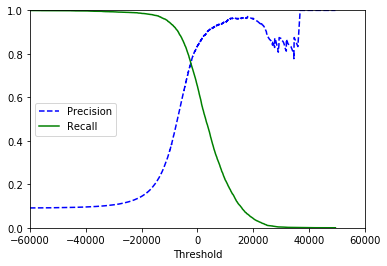

In [18]:
# Plotting a precision-recall curve using y_scores
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    plt.xlim([-60000,60000])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

We can use a precision v. recall graph to get a better sense of what the threshold should be:

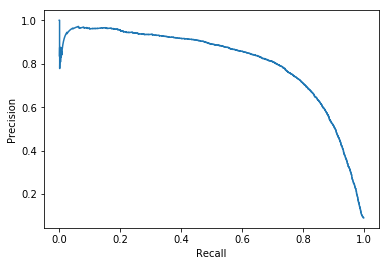

In [19]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    
plot_precision_vs_recall(precisions, recalls)

So, once you decide on a threshold, say 1,000, to make predictions, instead of calling the classifier's `predict()` method, you can just run the code:

In [20]:
y_train_pred_1k_thresh = (y_scores > 1000)

print('Precision:', precision_score(y_train_5, y_train_pred_1k_thresh))
print('Recall:', recall_score(y_train_5, y_train_pred_1k_thresh))

Precision: 0.857331571994716
Recall: 0.5985980446412101


### The ROC Curve
The **receiver operating characteristic (ROC)** curve is another common tool used with binary classifiers. Instead of plotting precision versus recall, it plots the *true positive rate* (another term for recall) against the *false positive rate*.

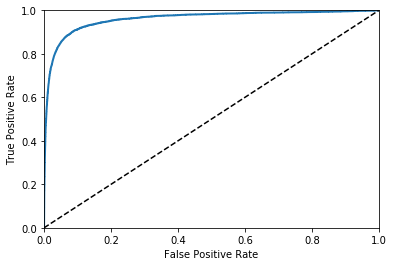

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)

"One way to compare classifiers is to measure the *area under the curve (AUC)*. A perfect classifier will have a **ROC AUC** equal to 1, whereas a purely random classifier will have a **ROC AUC** equal to 0.5."

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

*"Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few postives (5's) compared to the negatives (non-5's). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).*"

We will now train a `RandomForestClassifier` and compare its ROC cirve and ROC AUC to the SGDClassifier. Unfortunately, the RandomForestClassifier has a `predict_proba()` method which gives probabilities, instead of the `decision_functions()` method which gives decision scores, so we need to improvise.

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


To plot a ROC curve, we need scores, not probabilities. 'A simple solution is to use the positive class's probability as the score:'

In [24]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

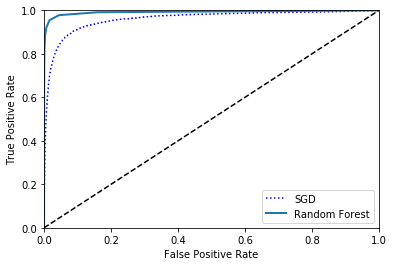

In [25]:
plt.plot(fpr,tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')

In [26]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

# Multiclass Classification

"Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are stricly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers."

One strategy is called **OvA** or **one-versus-all** strategy, where for mnist, 10 binary classifiers would be trained: a 0-detector, a 1-detector, a 2-detector, and so on. Then you get the decision scores of each binary classifier and your prediction would be the one with the highest score.

Another strategy is called **OvO** or **one-versus-one** strategy. In this, a binary classifier is trained to distinguish between each pair of digits. One would distinguish between 1's and 2's, another 1's and 3's, another 5's and 7's, etc. The issue here is that this results in a lot of classifiers. If you have N classes, you need to train N * (N-1) / 2 classifiers. "The main advantage of OvO is that each classifier oly needs to be trained on the part of the training set for the two classes that it must distinguish.

Luckily, "Scikit-Learn detects when you try to use a binary classification algorithm for a multi-class classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [28]:
sgd_clf.fit(x_train, y_train) # Using the full y_train with all 0-9 labels
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [29]:
# Let's tak a closer look at the decision scores that led to the Stochastic Gradient Descent classifier to predicting the 5.
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-19424.3180995 , -13976.66933087,  -9071.4053039 ,
         -7236.45238701, -13916.84999797,   -626.67657709,
        -40881.79035646,  -3892.94335332,  -1469.65047268,
         -5482.34701661]])

In [30]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

5

"If you want to force ScikitLearn to use OvO or OvA, you can use the `OneVsOneClassifier` or `OneVsAllClassifier` classes. Simply create an instance and pass a binary classifier to its constructor."

In [31]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [32]:
# The fitting process takes a lot longer because a OvO classifier for mnist has 45 classifiers, not 10 as in OvA.
len(ovo_clf.estimators_)

45

A RandomForestClassifer is able to do multiclass classification right out of the box and does not need to use OvO or OvA.

In [33]:
forest_clf.fit(x_train, y_train)
forest_clf.predict([some_digit])

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [34]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [ ]:
# Accuracy is a good measurement here because our dataset is not skewed.
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

In [ ]:
# We can improve our accuracy a little with the StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

### Error Analysis

Let's take a look at the confusion matrix:

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_max

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)